In [44]:
import xgboost as xgb
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

import seaborn as sns
sns.set(font='Yu Gothic')
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
def load_npy(hold_position):
    file_path = "../Output/validation/validation_" + hold_position + "/validation_" + hold_position
    xy_mean = np.load(file_path + "_glo_laccel_xy_mean.npy")
    xy_var = np.load(file_path + "_glo_laccel_xy_var.npy")
    z_mean = np.load(file_path + "_glo_laccel_z_mean.npy")
    z_var = np.load(file_path + "_glo_laccel_z_var.npy")
    z_skew = np.load(file_path + "_glo_laccel_z_skew.npy")
    z_kurtosis = np.load(file_path + "_glo_laccel_z_kurtosis.npy")
    z_lacc_FFT = np.load(file_path + "_glo_laccel_z_amplitude_frequency_range5Hz.npy")[:, 0:-1:2]
    z_gyro_FFT = np.load(file_path + "_glo_gyro_z_amplitude_frequency_range5Hz.npy")[:, 0:-1:2]
    result = np.concatenate([xy_mean.reshape([-1, 1]), xy_var.reshape([-1, 1]), z_mean.reshape([-1, 1]), z_var.reshape([-1, 1]), z_skew.reshape([-1, 1]), z_kurtosis.reshape([-1, 1]), z_lacc_FFT, z_gyro_FFT], axis=1)
    del xy_mean, xy_var, z_mean, z_var, z_skew, z_kurtosis, z_gyro_FFT
    return result

In [3]:
Bag = load_npy("Bag")
Hips = load_npy("Hips")
Torso = load_npy("Torso")
Hand = load_npy("Hand")

Hand.shape

(28685, 28)

In [4]:
user_label = np.load("../Data/センサ別npyファイル/validation/validation_UserLabel.npy")
user_label.shape

(28685, 1)

In [13]:
user2_Bag = Bag[:14813].copy()
user2_Hips = Hips[:14813].copy()
user2_Torso = Torso[:14813].copy()
user2_Hand = Hand[:14813].copy()

user3_Bag = Bag[14813:].copy()
user3_Hips = Hips[14813:]
user3_Torso = Torso[14813:]
user3_Hand = Hand[14813:]

user2_Hand.shape, user3_Hand.shape

((14813, 28), (13872, 28))

In [11]:
X = np.concatenate([Bag, Hips, Torso, Hand], axis=0)
x_mean = X.mean()
x_std = X.std()

In [12]:
def spliter(x):
    x_train, x_val = train_test_split(x, test_size=0.3, shuffle=False)
    return x_train, x_val

In [15]:
user2_Bag_train, user2_Bag_val = spliter(user2_Bag)
user2_Hips_train, user2_Hips_val = spliter(user2_Hips)
user2_Torso_train, user2_Torso_val = spliter(user2_Torso)
user2_Hand_train, user2_Hand_val = spliter(user2_Hand)

user3_Bag_train, user3_Bag_val = spliter(user3_Bag)
user3_Hips_train, user3_Hips_val = spliter(user3_Hips)
user3_Torso_train, user3_Torso_val = spliter(user3_Torso)
user3_Hand_train, user3_Hand_val = spliter(user3_Hand)

user2_Bag_train.shape, user2_Bag_val.shape, user3_Bag_train.shape, user3_Bag_val.shape

((10369, 28), (4444, 28), (9710, 28), (4162, 28))

In [16]:
X_train = np.concatenate([user2_Bag_train, user2_Hips_train, user2_Torso_train, user2_Hand_train, user3_Bag_train, user3_Hips_train, user3_Torso_train, user3_Hand_train])
X_val = np.concatenate([user2_Bag_val, user2_Hips_val, user2_Torso_val, user2_Hand_val, user3_Bag_val, user3_Hips_val, user3_Torso_val, user3_Hand_val])

X_train.shape, X_val.shape

((80316, 28), (34424, 28))

In [17]:
X_train = (X_train - x_mean) / x_std
X_val = (X_val - x_mean) / x_std

In [20]:
Y_train = [0] * 10369 * 4 + [1] * 9710 * 4
Y_val = [0] * 4444 * 4 + [1] * 4162 * 4

Y_train = np.array(Y_train).reshape([-1, 1])
Y_val = np.array(Y_val).reshape([-1, 1])

Y_train.shape, Y_val.shape

((80316, 1), (34424, 1))

In [46]:
model = xgb.XGBClassifier(max_depth=18, min_child_weight=4, learning_rate=0.1, 
                          n_jobs=-1, tree_method='gpu_hist', gpu_id=0)
model.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=18,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=False,
              verbosity=None)

In [47]:
def plot_confusion_matrix(test_y,pred_y,class_names,normalize=False, figsize=(16, 8)):
    cm = confusion_matrix(test_y,pred_y)
    # classes = class_names[unique_labels(test_y,pred_y)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names,
           yticklabels=class_names,
           ylabel='True label\n',
           xlabel='\nPredicted label')
    fmt = '.2f' if normalize else 'd'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,
                    i,
                    format(cm[i, j], fmt),
                    ha="center",
                    va="center",
                    color="red", fontsize=16)
    fig.tight_layout()
    return ax

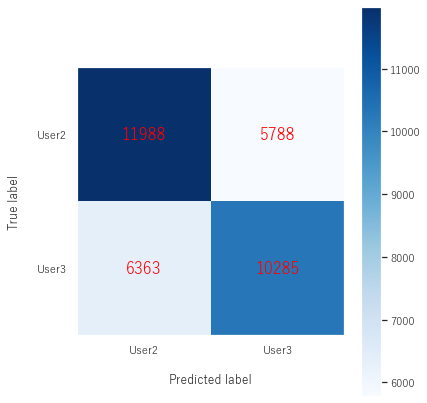

In [55]:
class_names = ['User2', 'User3']

predict = model.predict(X_val)
plot_confusion_matrix(Y_val, predict, class_names, False, figsize=(6, 6))
plt.grid(False)

In [49]:
X = np.concatenate([X_train, X_val], axis=0)
Y = np.concatenate([Y_train, Y_val], axis=0)

X.shape, Y.shape

((114740, 28), (114740, 1))

In [50]:
model2 = xgb.XGBClassifier(max_depth=18, min_child_weight=4, learning_rate=0.1, 
                          n_jobs=-1, tree_method='gpu_hist', gpu_id=0)
model2.fit(X, Y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=18,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=False,
              verbosity=None)

In [51]:
def load_npy():
    file_path = "../Output/test/test"
    xy_mean = np.load(file_path + "_glo_laccel_xy_mean.npy")
    xy_var = np.load(file_path + "_glo_laccel_xy_var.npy")
    z_mean = np.load(file_path + "_glo_laccel_z_mean.npy")
    z_var = np.load(file_path + "_glo_laccel_z_var.npy")
    z_skew = np.load(file_path + "_glo_laccel_z_skew.npy")
    z_kurtosis = np.load(file_path + "_glo_laccel_z_kurtosis.npy")
    z_lacc_FFT = np.load(file_path + "_glo_laccel_z_amplitude_frequency_range5Hz.npy")[:, 0:-1:2]
    z_gyro_FFT = np.load(file_path + "_glo_gyro_z_amplitude_frequency_range5Hz.npy")[:, 0:-1:2]
    result = np.concatenate([xy_mean.reshape([-1, 1]), xy_var.reshape([-1, 1]), z_mean.reshape([-1, 1]), z_var.reshape([-1, 1]), z_skew.reshape([-1, 1]), z_kurtosis.reshape([-1, 1]), z_lacc_FFT, z_gyro_FFT], axis=1)
    del xy_mean, xy_var, z_mean, z_var, z_skew, z_kurtosis, z_gyro_FFT
    return result

In [52]:
test = load_npy()
test = (test - x_mean) / x_std

In [53]:
predict = model.predict(test)

for i in range(len(class_names)):
    print("{}：{}".format(class_names[i], np.sum(predict==i)))

User2：41820
User3：15753


In [54]:
predict = model2.predict(test)

for i in range(len(class_names)):
    print("{}：{}".format(class_names[i], np.sum(predict==i)))

User2：39421
User3：18152


In [45]:
best_f1_score = 0
best_param = {}

max_depth = [16, 18, 20, 22]
min_child_weight = [4,7,10,13]
count = 1
for i in max_depth:
    for j in min_child_weight:
        model = xgb.XGBClassifier(max_depth=i, min_child_weight=j, learning_rate=0.1,
                                  n_jobs=-1, tree_method='gpu_hist', gpu_id=0)
        model.fit(X_train, Y_train)
        print("{}回終わった".format(count))
        count += 1
        predict = model.predict(X_val)
        f1_macro = f1_score(Y_val, predict, average='macro')
        print({'max_depth': i, 'min_child_weight': j}, f1_macro)
        if f1_macro > best_f1_score:
            best_f1_score = f1_macro
            best_param = {'max_depth': i, 'min_child_weight': j}

print(round(best_f1_score, 3))
print(best_param)

# param = {
#     "max_depth":[i for i in range(3, 16, 3)], "min_child_weight":[i for i in range(6, 13, 2)]
#     # "gamma":[0.01, 0.05, 0.075, 0.1]
#     # "subsample":[0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00], "colsample_bytree":[0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00]
#     # "n_estimators":[250, 500, 750], "learning_rate":[0.05, 0.1]
#     # "reg_alpha":[0.1, 0.25, 0.5, 0.75]
# }

1回終わった
{'max_depth': 16, 'min_child_weight': 4} 0.6419626910337564
2回終わった
{'max_depth': 16, 'min_child_weight': 7} 0.6374030633273178
3回終わった
{'max_depth': 16, 'min_child_weight': 10} 0.6332973126088768
4回終わった
{'max_depth': 16, 'min_child_weight': 13} 0.6327378122819436
5回終わった
{'max_depth': 18, 'min_child_weight': 4} 0.6461535140362942
6回終わった
{'max_depth': 18, 'min_child_weight': 7} 0.6388441799732252
7回終わった
{'max_depth': 18, 'min_child_weight': 10} 0.6346178766651938
8回終わった
{'max_depth': 18, 'min_child_weight': 13} 0.6339964090794665
9回終わった
{'max_depth': 20, 'min_child_weight': 4} 0.6412919576401794
10回終わった
{'max_depth': 20, 'min_child_weight': 7} 0.6414727447858588
11回終わった
{'max_depth': 20, 'min_child_weight': 10} 0.6344490694512721
12回終わった
{'max_depth': 20, 'min_child_weight': 13} 0.637440649281828
13回終わった
{'max_depth': 22, 'min_child_weight': 4} 0.6438605676831144
14回終わった
{'max_depth': 22, 'min_child_weight': 7} 0.6381150719636193
15回終わった
{'max_depth': 22, 'min_child_weight': 10} 0.